# پروژه ۴ و ۵: خوشه‌بندی با K-means و HAC

این نوت‌بوک شامل پیاده‌سازی کامل الگوریتم‌های K-means و خوشه‌بندی سلسله‌مراتبی تجمعی (HAC) روی مجموعه‌داده Customer marketing است.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display


def persian_text(text):
    reshaped = arabic_reshaper.reshape(text)
    return get_display(reshaped)

    
plt.style.use("seaborn-v0_8")
%matplotlib inline


## ۱) بارگذاری و پیش‌پردازش داده

فایل داده در پوشه `data` قرار دارد. در این قسمت چند ویژگی عددی مرتبط را انتخاب و نرمال‌سازی می‌کنیم.


In [2]:
data_path = "data/Customer marketing.csv"
df = pd.read_csv(data_path, sep="\t")
df.head()


,ID_,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
numeric_features = [
    "Income",
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth",
]

df_numeric = df[numeric_features].dropna()
X = df_numeric.values.astype(float)

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1.0
X_scaled = (X - X_mean) / X_std
X_scaled.shape


(2216, 12)

## ۲) پیاده‌سازی الگوریتم K-means

در این بخش K-means را با مقداردهی اولیه تصادفی مراکز، معیار توقف بر اساس تغییر مراکز و محاسبه تابع هزینه (SSE) پیاده‌سازی می‌کنیم.


In [4]:
def kmeans(X, k, max_iters=100, tol=1e-4, random_state=None):
    rng = np.random.default_rng(random_state)
    n_samples = X.shape[0]
    indices = rng.choice(n_samples, size=k, replace=False)
    centroids = X[indices].copy()

    for it in range(max_iters):
        distances = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.zeros_like(centroids)
        for j in range(k):
            mask = labels == j
            if np.any(mask):
                new_centroids[j] = X[mask].mean(axis=0)
            else:
                new_centroids[j] = X[rng.integers(0, n_samples)]

        shift = np.linalg.norm(new_centroids - centroids)
        centroids = new_centroids
        if shift < tol:
            break

    distances = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
    labels = np.argmin(distances, axis=1)
    sse = np.sum((X - centroids[labels]) ** 2)

    return labels, centroids, sse, it + 1


In [5]:
def run_kmeans_for_ks(X, ks, n_init=5, max_iters=100, tol=1e-4, random_state=0):
    best_sses = []
    best_iters = []

    for k in ks:
        sse_list = []
        it_list = []
        for i in range(n_init):
            seed = None if random_state is None else random_state + i
            _, _, sse, iters = kmeans(X, k, max_iters=max_iters, tol=tol, random_state=seed)
            sse_list.append(sse)
            it_list.append(iters)

        best_sses.append(min(sse_list))
        best_iters.append(np.mean(it_list))

    return np.array(best_sses), np.array(best_iters)

ks = list(range(2, 11))
kmeans_sses, kmeans_iters = run_kmeans_for_ks(X_scaled, ks, n_init=5, max_iters=100, tol=1e-4, random_state=0)
kmeans_sses, kmeans_iters


(array([16664.27776253, 14100.31694505, 13109.20206637, 12319.478137  ,
        11791.12035407, 11348.98028286, 10968.41016479, 10462.65089003,
        10343.97706402]),
 array([ 9. , 17. , 20.6, 25.2, 32.8, 24.8, 40.8, 44.6, 31.6]))

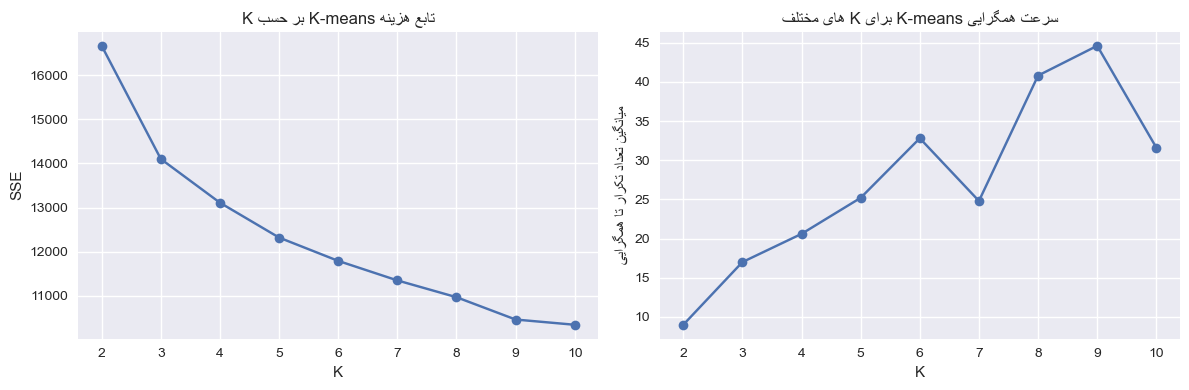

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(ks, kmeans_sses, marker="o")
axes[0].set_xlabel("K")
axes[0].set_ylabel("SSE")
axes[0].set_title(persian_text("تابع هزینه K-means بر حسب K"))

axes[1].plot(ks, kmeans_iters, marker="o")
axes[1].set_xlabel("K")
axes[1].set_ylabel(persian_text("میانگین تعداد تکرار تا همگرایی"))
axes[1].set_title(persian_text("سرعت همگرایی K-means برای K های مختلف"))

plt.tight_layout()
plt.show()


## ۳) پیاده‌سازی HAC (خوشه‌بندی سلسله‌مراتبی تجمعی)

در این قسمت HAC را برای دو نوع لینک زیر پیاده‌سازی می‌کنیم:

- نزدیک‌ترین زوج (Single Linkage)
- دورترین زوج (Complete Linkage)

برای جلوگیری از پیچیدگی محاسباتی بسیار زیاد، HAC روی یک زیرمجموعه محدود از داده‌ها اجرا می‌شود.


In [7]:
def sample_for_hac(X, max_samples=300, random_state=0):
    rng = np.random.default_rng(random_state)
    n = X.shape[0]
    if n <= max_samples:
        return X
    indices = rng.choice(n, size=max_samples, replace=False)
    return X[indices]

X_hac = sample_for_hac(X_scaled, max_samples=300, random_state=0)
X_hac.shape


(300, 12)

In [8]:
def pairwise_distances(X):
    diff = X[:, None, :] - X[None, :, :]
    return np.linalg.norm(diff, axis=2)

def compute_sse_for_clusters(X, clusters):
    sse = 0.0
    for idx in clusters:
        points = X[idx]
        center = points.mean(axis=0)
        diff = points - center
        sse += np.sum(diff ** 2)
    return sse

def hac_costs(X, linkage="single"):
    n = X.shape[0]
    base_dist = pairwise_distances(X)
    np.fill_diagonal(base_dist, np.inf)

    clusters = [np.array([i]) for i in range(n)]
    cluster_dist = base_dist.copy()

    ks = [n]
    sses = [0.0]

    while len(clusters) > 1:
        m = len(clusters)
        i, j = divmod(np.argmin(cluster_dist), m)
        if i == j:
            break
        if i > j:
            i, j = j, i

        new_cluster = np.concatenate([clusters[i], clusters[j]])
        clusters[i] = new_cluster
        del clusters[j]

        new_dist = np.full((m - 1, m - 1), np.inf)
        for a in range(m - 1):
            for b in range(a + 1, m - 1):
                if a == i:
                    if b >= j:
                        d1 = cluster_dist[i, b + 1]
                        d2 = cluster_dist[j, b + 1]
                    else:
                        d1 = cluster_dist[i, b]
                        d2 = cluster_dist[j, b]
                    if linkage == "single":
                        d = min(d1, d2)
                    else:
                        d = max(d1, d2)
                    new_dist[i, b] = d
                    new_dist[b, i] = d
                else:
                    ai = a if a < j else a + 1
                    bi = b if b < j else b + 1
                    d = cluster_dist[ai, bi]
                    new_dist[a, b] = d
                    new_dist[b, a] = d

        cluster_dist = new_dist
        np.fill_diagonal(cluster_dist, np.inf)

        sse = compute_sse_for_clusters(X, clusters)
        ks.append(len(clusters))
        sses.append(sse)

    ks = np.array(ks)
    sses = np.array(sses)
    order = np.argsort(ks)
    ks_sorted = ks[order]
    sses_sorted = sses[order]
    return ks_sorted, sses_sorted

hac_ks_single, hac_sses_single = hac_costs(X_hac, linkage="single")
hac_ks_complete, hac_sses_complete = hac_costs(X_hac, linkage="complete")
hac_ks_single[:10], hac_sses_single[:10]


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([3364.22594133, 3242.80837248, 3181.8760797 , 3130.00151266,
        3083.51261328, 3037.18427258, 3005.26302589, 2964.02581272,
        2838.11176014, 2735.31818772]))

## ۴) رسم تابع هزینه HAC برای K های مختلف و مقایسه با K-means

در این قسمت SSE را برای مقادیر مختلف K از هر دو روش محاسبه و مقایسه می‌کنیم.


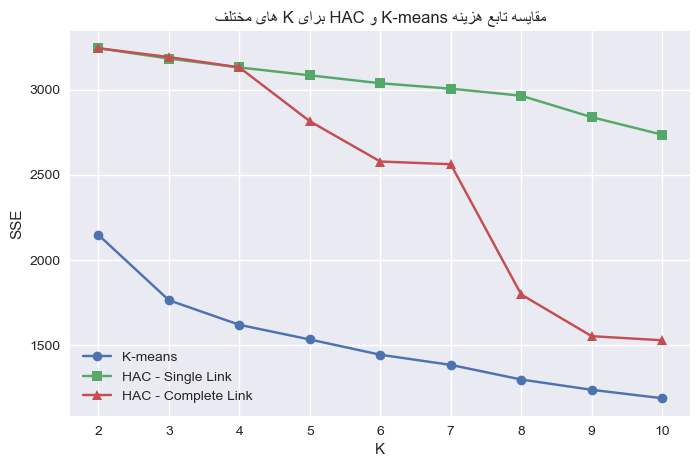

In [9]:
def extract_sses_for_target_ks(hac_ks, hac_sses, target_ks):
    result = []
    for k in target_ks:
        mask = hac_ks == k
        if np.any(mask):
            result.append(float(hac_sses[mask][0]))
        else:
            result.append(np.nan)
    return np.array(result)

ks_compare = ks
hac_single_sses_for_ks = extract_sses_for_target_ks(hac_ks_single, hac_sses_single, ks_compare)
hac_complete_sses_for_ks = extract_sses_for_target_ks(hac_ks_complete, hac_sses_complete, ks_compare)

kmeans_sses_subset, _ = run_kmeans_for_ks(X_hac, ks_compare, n_init=5, max_iters=100, tol=1e-4, random_state=0)

plt.figure(figsize=(8, 5))
plt.plot(ks_compare, kmeans_sses_subset, marker="o", label="K-means")
plt.plot(ks_compare, hac_single_sses_for_ks, marker="s", label="HAC - Single Link")
plt.plot(ks_compare, hac_complete_sses_for_ks, marker="^", label="HAC - Complete Link")
plt.xlabel("K")
plt.ylabel("SSE")
plt.title(persian_text("مقایسه تابع هزینه K-means و HAC برای K های مختلف"))
plt.legend()
plt.grid(True)
plt.show()


در این نمودار می‌توان رفتار تابع هزینه بر حسب تعداد خوشه K را برای الگوریتم K-means و همچنین HAC با دو نوع لینک مشاهده و مقایسه کرد. از روی این منحنی‌ها می‌توان مقدار مناسب K را (مثلاً با روش آرنج) انتخاب و درباره تفاوت عملکرد دو الگوریتم بحث کرد.
